# Парсинг детской литературы с сайта Читай-Город

**Пользователь информации: потребитель**
    
**Цель** - собрать исчерпывающую информацию о каждом издании, на основе которой, применив фильтры и сортировку, можно принять решение о покупке, а также с лёгкостью найти понравившуюся книгу.
    
   **Задачи:**
    
    1. Определить список полей, интересных для парсинга со страницы каждой книги.
    2. Написать код для сбора информации со страницы одной книги.
    3. Написать цикл для прохода по всем ссылкам, сбора необходимой информации и записи её в файл.

## Определим список полей, интересных для сбора.

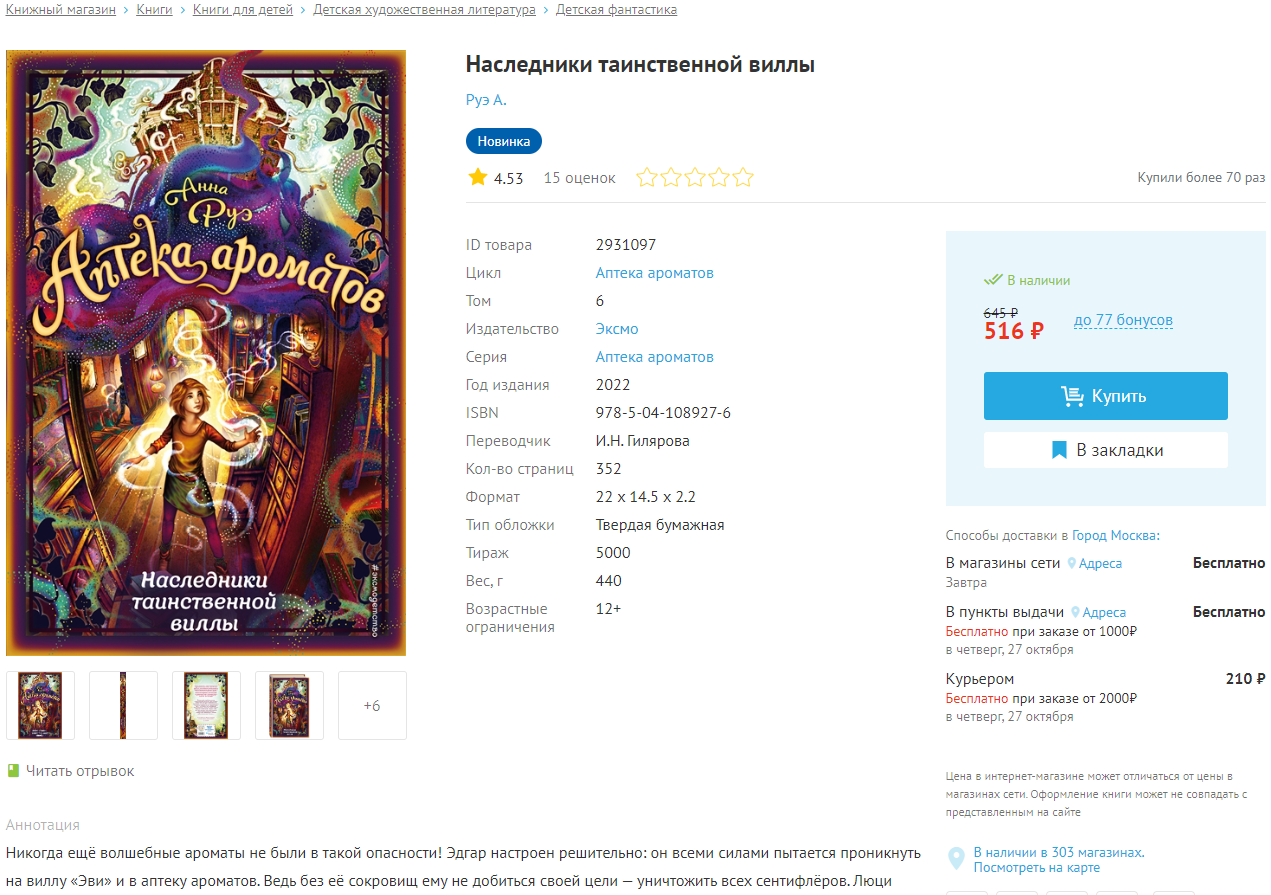

- Информация об издании:
    - Название
    - Автор
    - Цикл
    - Том
    - Издательство
    - Серия
    - Переводчик
    - Художник
    - Год издания
    - Возрастные ограничения
    - ISBN
- Количественная информация:
    - Цена
    - Цена со скидкой
    - Рейтинг
    - Количество оценок
- Информация магазина: 
    - ID товара
    - Категории
    - Аннотация
    - Ссылка на отрывок
    - Ссылка на обложку 
- Физические характеристики:
    - Кол-во страниц
    - Тип обложки
    - Формат
    - Вес
- Наличие:
    - Тираж
    - Наличие на сайте
    - Начало продаж
    - Наличие в магазинах
    - Ссылка на карту

## Напишем код для парсинга

In [2]:
# Импортируем библиотеки, которые скорее всего понядобятся.

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm.notebook import tqdm
import re

In [160]:
# Создаём списки, в которые будут записываться свойства каждой книги.

isbn = []
name = []
author = []
series = []
volume = []
publisher = []
series_pub = []
year = []
age = []
translator = []
artist = []
price = []
sale_price = []
rating = []
rating_n = []
book_id = []
cat_1 = []
cat_2 = []
about = []
extract = []
picture = []
pages_n = []
cover = []
dimensions = []
weight = []
issue = []
quantity = []
start = []
shops = []
local_shops = []
shops_map = []

# Создаём словарь для записи всей информации.

data = {'ID товара': book_id, 'Название': name, 'Автор': author, 'Цикл': series, 'Том': volume,
        'Категория': cat_1, 'Подкатегории': cat_2,'Издательство': publisher, 'Серия': series_pub,
        'Год издания': year, 'Возрастные ограничения': age, 'Переводчик': translator,
        'Художник': artist, 'Цена': price, 'Цена со скидкой': sale_price, 'Рейтинг': rating,
        'Кол-во оценок': rating_n, 'ISBN': isbn, 'Аннотация': about, 'Отрывок': extract,
        'Обложка': picture, 'Кол-во страниц': pages_n, 'Тип обложки': cover, 'Формат': dimensions,
        'Вес': weight, 'Тираж': issue, 'Наличие на сайте': quantity, 'Поступит в продажу': start,
        'Наличие в магазинах': shops, 'Наличие в местных магазинах': local_shops, 'Карта': shops_map}

properties = [isbn, name, author, series, volume, publisher, series_pub, year, age, translator, artist, price,
              sale_price, rating, rating_n, book_id, cat_1, cat_2, about, extract, picture, pages_n, cover,
              dimensions, weight, issue, quantity, start, shops, local_shops, shops_map]

# Списки со страницами выдачи и ссылками на книги для фиксации ошибок.

page_error = []
book_error = []

## Цикл для прохода по страницам и заполнения словаря.

In [61]:
# Парсим первую страницу выдачи.

url = 'https://www.chitai-gorod.ru/catalog/books/knigi_dlya_detey-9072/'
response = requests.get(url) 
tree = BeautifulSoup(response.content, 'html.parser')

# Находим количество страниц выдачи.

n = int(tree.find('div', {'class': 'pagination'}).find_all('a', {'class': 'pagination-item'})[-2].text)

# Зафиксируем n. Это нужно для продолжения парсинга в другой раз.

print(n)

# Запускаем цикл для страниц поисковой выдачи от 1 до n (или для другого интервала).
# Сайт Читай-Города не воинственный, поэтому можно обойтись без сна и маскировки.

for p in tqdm(range(402, n)):
    try:
        if p == 1:
            url = 'https://www.chitai-gorod.ru/catalog/books/knigi_dlya_detey-9072/'
        else:
            url = 'https://www.chitai-gorod.ru/catalog/books/knigi_dlya_detey-9072/?page={}'.format(p)   
        response = requests.get(url)
        tree = BeautifulSoup(response.content, 'html.parser')

        books = tree.find_all('div', {'class': 'product-card js_product js__product_card js__slider_item'})

        for book in books:
            
# Найдём по ссылке и распарсим страницу книги.
            
            book_url = 'https://www.chitai-gorod.ru' + book.a.get('href')
        
            try:
                
# Выделим для удобства большую часть кода в отдельную функцию, которая описана ниже.

                book_parse(book_url)
    
            except:
                
# В случае ошибки на странице книги обновляем, записываем в файл и печатаем лог.                
                
                book_error.append(book_url)
        
                with open('book_error.text', 'a') as log:
                    log.write(book_error[-1] + '\n')
                    
                print(str(p) + ' ' + book_error[-1])
            
# И полностью удаляем битую книгу, чтобы все списки были одинаковой длины. 
            
                for i in range(len(properties)):
                    for j in range(len(properties)):
                        if len(properties[i]) > len(properties[j]):
                            properties[i].pop(-1)

# С периодичностью раз в страницу выдачи обновляем словарь и записываем его в csv файл через pandas DataFrame. 
        
        data.update()
        
        df = pd.DataFrame(data)
        df.to_csv('parsed_chitay_gorod_kids_02.csv', index=False)
        
    except:
        
# В случае ошибки на странице выдачи обновляем, записываем в файл и печатаем лог.
        
        page_error.append(p)
        
        with open('page_error.text', 'a') as log:
            log.write(page_error[-1] + '\n')
                    
        print(page_error[-1])

1905


  0%|          | 0/1503 [00:00<?, ?it/s]

1009 https://www.chitai-gorod.ru/catalog/book/1058204/
1016 https://www.chitai-gorod.ru/catalog/book/1056271/
1307 https://www.chitai-gorod.ru/catalog/book/826522/
1324 https://www.chitai-gorod.ru/catalog/book/785136/
1324 https://www.chitai-gorod.ru/catalog/book/784916/
1324 https://www.chitai-gorod.ru/catalog/book/784861/
1324 https://www.chitai-gorod.ru/catalog/book/784860/
1344 https://www.chitai-gorod.ru/catalog/book/738092/
1344 https://www.chitai-gorod.ru/catalog/book/738091/
1344 https://www.chitai-gorod.ru/catalog/book/738090/
1344 https://www.chitai-gorod.ru/catalog/book/738088/
1344 https://www.chitai-gorod.ru/catalog/book/738080/
1344 https://www.chitai-gorod.ru/catalog/book/738079/
1344 https://www.chitai-gorod.ru/catalog/book/738078/
1344 https://www.chitai-gorod.ru/catalog/book/737677/
1344 https://www.chitai-gorod.ru/catalog/book/737666/
1344 https://www.chitai-gorod.ru/catalog/book/737451/
1344 https://www.chitai-gorod.ru/catalog/book/737076/
1344 https://www.chitai-go

1453 https://www.chitai-gorod.ru/catalog/book/2881082/
1453 https://www.chitai-gorod.ru/catalog/book/2880512/
1453 https://www.chitai-gorod.ru/catalog/book/2879934/
1454 https://www.chitai-gorod.ru/catalog/book/2879026/
1454 https://www.chitai-gorod.ru/catalog/book/2878747/
1454 https://www.chitai-gorod.ru/catalog/book/2878029/
1454 https://www.chitai-gorod.ru/catalog/book/2878016/
1454 https://www.chitai-gorod.ru/catalog/book/2878015/
1454 https://www.chitai-gorod.ru/catalog/book/2878011/
1454 https://www.chitai-gorod.ru/catalog/book/2878008/
1454 https://www.chitai-gorod.ru/catalog/book/2878007/
1455 https://www.chitai-gorod.ru/catalog/book/2878001/
1455 https://www.chitai-gorod.ru/catalog/book/2878000/
1455 https://www.chitai-gorod.ru/catalog/book/2877936/
1455 https://www.chitai-gorod.ru/catalog/book/2877093/
1455 https://www.chitai-gorod.ru/catalog/book/2877092/
1455 https://www.chitai-gorod.ru/catalog/book/2876385/
1456 https://www.chitai-gorod.ru/catalog/book/2876049/
1456 https

1503 https://www.chitai-gorod.ru/catalog/book/1254058/
1503 https://www.chitai-gorod.ru/catalog/book/1254054/
1504 https://www.chitai-gorod.ru/catalog/book/1254048/
1504 https://www.chitai-gorod.ru/catalog/book/1254039/
1504 https://www.chitai-gorod.ru/catalog/book/1254038/
1505 https://www.chitai-gorod.ru/catalog/book/1253358/
1506 https://www.chitai-gorod.ru/catalog/book/1250025/
1507 https://www.chitai-gorod.ru/catalog/book/1249013/
1507 https://www.chitai-gorod.ru/catalog/book/1249011/
1507 https://www.chitai-gorod.ru/catalog/book/1248926/
1507 https://www.chitai-gorod.ru/catalog/book/1248921/
1509 https://www.chitai-gorod.ru/catalog/book/1247023/
1509 https://www.chitai-gorod.ru/catalog/book/1245847/
1509 https://www.chitai-gorod.ru/catalog/book/1245845/
1510 https://www.chitai-gorod.ru/catalog/book/1245652/
1512 https://www.chitai-gorod.ru/catalog/book/1243029/
1513 https://www.chitai-gorod.ru/catalog/book/1242580/
1513 https://www.chitai-gorod.ru/catalog/book/1242252/
1513 https

1634 https://www.chitai-gorod.ru/catalog/book/1074557/
1635 https://www.chitai-gorod.ru/catalog/book/1074329/
1645 https://www.chitai-gorod.ru/catalog/book/1072082/
1651 https://www.chitai-gorod.ru/catalog/book/1069169/
1651 https://www.chitai-gorod.ru/catalog/book/1069109/
1652 https://www.chitai-gorod.ru/catalog/book/1069011/
1653 https://www.chitai-gorod.ru/catalog/book/1068645/
1654 https://www.chitai-gorod.ru/catalog/book/1067535/
1655 https://www.chitai-gorod.ru/catalog/book/1066807/
1655 https://www.chitai-gorod.ru/catalog/book/1066632/
1655 https://www.chitai-gorod.ru/catalog/book/1066292/
1656 https://www.chitai-gorod.ru/catalog/book/1065681/
1657 https://www.chitai-gorod.ru/catalog/book/1065341/
1661 https://www.chitai-gorod.ru/catalog/book/1062037/
1662 https://www.chitai-gorod.ru/catalog/book/1062022/
1662 https://www.chitai-gorod.ru/catalog/book/1061687/
1663 https://www.chitai-gorod.ru/catalog/book/1061384/
1664 https://www.chitai-gorod.ru/catalog/book/1060510/
1667 https

1789 https://www.chitai-gorod.ru/catalog/book/912383/
1790 https://www.chitai-gorod.ru/catalog/book/911352/
1791 https://www.chitai-gorod.ru/catalog/book/910413/
1791 https://www.chitai-gorod.ru/catalog/book/910410/
1792 https://www.chitai-gorod.ru/catalog/book/904468/
1794 https://www.chitai-gorod.ru/catalog/book/900540/
1795 https://www.chitai-gorod.ru/catalog/book/898909/
1796 https://www.chitai-gorod.ru/catalog/book/898801/
1799 https://www.chitai-gorod.ru/catalog/book/891969/
1802 https://www.chitai-gorod.ru/catalog/book/886367/
1805 https://www.chitai-gorod.ru/catalog/book/882493/
1807 https://www.chitai-gorod.ru/catalog/book/876941/
1810 https://www.chitai-gorod.ru/catalog/book/873168/
1811 https://www.chitai-gorod.ru/catalog/book/871242/
1811 https://www.chitai-gorod.ru/catalog/book/869391/
1811 https://www.chitai-gorod.ru/catalog/book/869270/
1813 https://www.chitai-gorod.ru/catalog/book/866863/
1814 https://www.chitai-gorod.ru/catalog/book/866306/
1814 https://www.chitai-goro

1905

## Функция для парсинга страницы одной книги.

In [159]:
def book_parse(book_url):

    book_response = requests.get(book_url)
    book_tree = BeautifulSoup(book_response.content, 'html.parser')

# Найдём раздел, где лежит вся нужная нам информация о книге.
                
    main = book_tree.find('div', {'class': 'product js-analytic-product-page js_product'})
        
# У разных книг разный набор свойств. Многие из них лежат в разделе класса 'product-prop'.
# Для каждой книги будем создавать словарь props, чтобы потом проверять по нему наличие того или иного свойства,
# а заодно быстро доставать его значение:

    props = {prop.find('div', {'class': 'product-prop__title'}).text:
             prop.find('div', {'class': 'product-prop__value'}).text.strip()
             for prop in main.find_all('div', {'class': 'product-prop'})}

# Напишем код, который будет проверять наличие свойств и добавлять их значения в списки.
# Если у книги нет того или иного свойства, на месте его значения будет стоять '-'.

    if main.find('span', {'itemprop': 'isbn'}) != None:
        isbn.append(main.find('span', {'itemprop': 'isbn'}).text)
    else:
        isbn.append('-')

    if main.get('data-book-id') != '':    
        book_id.append(main.get('data-book-id'))
    else:
        book_id.append('-')
            
    if main.get('data-chg-book-name') != '':    
        name.append(main.get('data-chg-book-name'))
    else:
        name.append('-')

    if main.find('a', {'class': 'link product__author'}) != None:
        author.append(main.find('a', {'class': 'link product__author'}).text.strip())
    else:
        author.append('-')

    if 'Цикл' in props:
        series.append(props['Цикл'])
    else:
        series.append('-')  

    if 'Том' in props:
        volume.append(props['Том'])
    else:
        volume.append('-')

    if main.get('data-productbrand') != '':    
        publisher.append(main.get('data-productbrand'))
    else:
        publisher.append('-')

    if 'Серия' in props:
        series_pub.append(props['Серия'])
    else:
        series_pub.append('-')
                
    if 'Год издания' in props:
        year.append(props['Год издания'])
    else:
        year.append('-')
        
    if 'Возрастные ограничения' in props:
        age.append(props['Возрастные ограничения'])
    else:
        age.append('-')

    if 'Переводчик' in props:
        translator.append(props['Переводчик'])
    else:
        translator.append('-')

    if 'Художник' in props:
        artist.append(props['Художник'])
    else:
        artist.append('-')

    price.append(main.get('data-chg-price'))

# Если на книгу нет скидки, цена со скидкой будет совпадать с обычной ценой.

    if main.get('data-chg-sale-price') != '':
        sale_price.append(main.get('data-chg-sale-price'))
    else:
         sale_price.append(main.get('data-chg-price'))

    rating.append(float(main.find('span', {'class': 'js__rating_count'}).text))
    rating_n.append(int(main.find('span', {'class': 'star-rating__text js__star_rating_text'}).text.split()[0]))

# У каждого детского издания есть главная подкатегория (например, детская художественная литература).
# Посвятим ей отдельный столбец. Дальнейшие разбивки (чаще всего она будет одна) занесём в один столбец через '/'.

    cat_1.append(main.get('data-productcategory').split('/')[1])
    cat_2.append('/'.join(main.get('data-productcategory').split('/')[2:]))
                
    about.append(main.find('div', {'itemprop': 'description'}).text.strip().replace('\n', ' '))

    if main.find('a', {'class': 'product-media__read_path'}) != None:
        extract.append(main.find('a', {'class': 'product-media__read_path'}).get('href'))
    else:
        extract.append('-')

    picture.append(main.find('div', {'class': 'product__image js__show_gallery'}).img.get('data-src'))

    if 'Кол-во страниц' in props:
        pages_n.append(props['Кол-во страниц'])
    else:
        pages_n.append('-')

    if 'Тип обложки' in props:
        cover.append(props['Тип обложки'])
    else:
        cover.append('-')

    if 'Формат' in props:
        dimensions.append(props['Формат'])
    else:
        dimensions.append('-') 

    if 'Вес, г' in props:
        weight.append(int(props['Вес, г']))
    else:
        weight.append('-') 

    if 'Тираж' in props:
        issue.append(int(props['Тираж']))
    else:
        issue.append('-')

# В зависимости от наличия книги на сайте, меняется текст кнопки, обычно отвечающей за покупку.
# Но сама кнопка есть всегда, и её текст будет индикатором проверки.
# Если предзаказ, то на сайте написано, когда книга поступит в продажу. Соберём и это.

    if main.find('button', {'class': 
                            'button button_product product-action js__product_card_button js__button-detail'}) != None:
        if main.find('span', {'class': 'js__card_button_text'}).text.strip() == 'Купить':
            quantity.append(main.find('div', {'class': 'quantity'}).text.strip())
            start.append('-')
        elif main.find('span', {'class': 'js__card_button_text'}).text.strip() == 'Предзаказ':
            quantity.append('Предзаказ')
            start.append('В ' + main.find('div', {'class': 'note'}).find('span').text)
        else:
            quantity.append('Нет в наличии')
            start.append('-')
    else:
        quantity.append('Нет в наличии')
        start.append('-')

# Соберём, если есть, данные о наличии книги в магазинах. А также сходим по ссылке на карту и возьмём оттуда наличие
# книги в местных магазинах города по умолчанию. Саму ссылку тоже заберём в завершающий столбец.

    if main.find('a', {'data-action': 'view-in-stock'}) != None:
        shops_n = re.search(r'\d+', main.find('div', {'class': 'in-stock-text'}).text).group(0)
        if 5 <= int(shops_n) <= 20:
            ending = 'ов'
        else:
            if shops_n[-1] == '1':
                ending = ''
            elif shops_n[-1] == '2' or shops_n[-1] == '3' or shops_n[-1] == '4':
                ending = 'а'
            else:
                ending = 'ов'
        shops.append(shops_n + ' магазин' + ending)
        shops_url = 'https://www.chitai-gorod.ru' + main.find('a', {'data-action': 'view-in-stock'}).get('href')
        shops_response = requests.get(shops_url)
        shops_tree = BeautifulSoup(shops_response.content, 'html.parser')
        if len(re.findall(r'\d+', shops_tree.find_all('div', {'class': 'shop__info-content'})[0].text)) != 0:
            shops_n = re.search(r'\d+', shops_tree.find_all
                                ('div', {'class': 'shop__info-content'})[0].text).group(0)
            if 5 <= int(shops_n) <= 20:
                ending = 'ов'
            else:
                if shops_n[-1] == '1':
                    ending = ''
                elif shops_n[-1] == '2' or shops_n[-1] == '3' or shops_n[-1] == '4':
                    ending = 'а'
                else:
                    ending = 'ов'
            city = shops_tree.find_all('div', {'class': 'shop__info-title'})[0].text.replace('Город ', '')
            local_shops.append(f'{shops_n} магазин{ending} ({city})')
        else:
            local_shops.append('-')
        shops_map.append(shops_url)
    else:
        shops.append('-')
        local_shops.append('-')
        shops_map.append('-')

## Считаем то, что получилось, из файла.

In [66]:
df2 = pd.read_csv('parsed_chitay_gorod_kids_02.csv')
print(df2.shape)
df2.tail()

(33140, 31)


C:\Users\Klim\AppData\Local\Temp\ipykernel_18604\2973129697.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('parsed_chitay_gorod_kids_02.csv')


,ID товара,Название,Автор,Цикл,Том,Категория,Подкатегории,Издательство,Серия,Год издания,...,Кол-во страниц,Тип обложки,Формат,Вес,Тираж,Наличие на сайте,Поступит в продажу,Наличие в магазинах,Наличие в местных магазинах,Карта
33135,2020698,Цивилизации Древнего Мира,Фпансуаза Перруден,-,-,Детская научно-популярная литература,Общественные науки,Махаон,Детская энциклопедия Махаон,2016,...,128,Твердая глянцевая,24.3 x 20.1 x 1.3,430,3000,Нет в наличии,-,97 магазинов,12 магазинов (Москва),https://www.chitai-gorod.ru/shops/reserve/?ele...
33136,1903329,Все вредные советы,Остер Г.,-,-,Детская художественная литература,Сказки,Планета детства,-,2018,...,-,Твердая глянцевая,21.8 x 15 x 3,720,-,Нет в наличии,-,146 магазинов,17 магазинов (Москва),https://www.chitai-gorod.ru/shops/reserve/?ele...
33137,1898902,Рисование. Первые шаги,Селиверстова Диана,-,-,Детское творчество и досуг,Рисование,Эксмо-Пресс,Школа юного художника,2016,...,352,Твердая глянцевая,26.4 x 20.4 x 2.3,920,3000,Нет в наличии,-,368 магазинов,55 магазинов (Москва),https://www.chitai-gorod.ru/shops/reserve/?ele...
33138,1896619,Маяковский Стихи детям,Маяковский В.,-,-,Детская художественная литература,Стихи и песни,Эксмо-Пресс,Стихи и сказки для детей,2019,...,144,Твердая глянцевая,26.5 x 20.5 x 2,760,-,Нет в наличии,-,74 магазина,4 магазина (Москва),https://www.chitai-gorod.ru/shops/reserve/?ele...
33139,1894638,Что такое хорошо,Маяковский В.,-,-,Детская художественная литература,Стихи и песни,Эксмо-Пресс,Мои любимые стихи,2018,...,176,Твердая глянцевая,16.2 x 15 x 2.2,390,-,Нет в наличии,-,119 магазинов,7 магазинов (Москва),https://www.chitai-gorod.ru/shops/reserve/?ele...


In [67]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33140 entries, 0 to 33139
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    33140 non-null  int64  
 1   Название                     33140 non-null  object 
 2   Автор                        33140 non-null  object 
 3   Цикл                         33140 non-null  object 
 4   Том                          33140 non-null  object 
 5   Категория                    33140 non-null  object 
 6   Подкатегории                 32686 non-null  object 
 7   Издательство                 33140 non-null  object 
 8   Серия                        33140 non-null  object 
 9   Год издания                  33140 non-null  object 
 10  Возрастные ограничения       33140 non-null  object 
 11  Переводчик                   33140 non-null  object 
 12  Художник                     33140 non-null  object 
 13  Цена            

In [176]:
df2.info

<bound method DataFrame.info of        ID товара                                Название               Автор  \
0        2837513                                   Аутар       Надежда Чупак   
1        2837632               Большое приключение Моаны      Сьюзан Фрэнсис   
2        2837633               Мальчик, который знал всё   Виктория Форестер   
3        2837634                        Дело о невидимке    Фрауке Шойнеманн   
4        2837641  Альбом самой классной девочки на свете        Гудкова Анна   
...          ...                                     ...                 ...   
33135    2020698               Цивилизации Древнего Мира  Фпансуаза Перруден   
33136    1903329                      Все вредные советы            Остер Г.   
33137    1898902                  Рисование. Первые шаги  Селиверстова Диана   
33138    1896619                  Маяковский Стихи детям       Маяковский В.   
33139    1894638                        Что такое хорошо       Маяковский В.   

       

In [70]:
df2.loc[25000]

ID товара                                                                2758890
Название                       Леди Баг и Супер-Кот. Раскраска. Зимнее приклю...
Автор                                                    Боярская С. (отв. ред.)
Цикл                                                                           -
Том                                                                            -
Категория                                      Детская художественная литература
Подкатегории                                                           Раскраски
Издательство                                                                 АСТ
Серия                                 Леди Баг и Супер-Кот. Раскраски и активити
Год издания                                                                 2019
Возрастные ограничения                                                        6+
Переводчик                                                                     -
Художник                    

In [175]:
# Выведем полностью аннотацию.

df2.loc[25000]['Аннотация']

'Маринетт и Эдриан ходят в школу, общаются с друзьями, но, когда городу угрожает опасность, перевоплощаются в Леди Баг и Супер-Кота! Теперь их ждёт удивительное новогоднее приключение. Раскрась супергероев и помоги им спасти Париж от акум Бражника!'

## Перепишем функцию для сбора url из лога ошибок.

In [31]:
with open('book_error.text', 'r') as log:
    books = list(log)
        
for book in tqdm(range(len(books))):
            
# Найдём по ссылке и распарсим страницу книги.
            
    book_url = books[book].strip()
    
    try:
        book_parse(book_url)
    except:
                
# В случае ошибки на странице книги обновляем и печатаем новый лог.                
                
        book_error.append(book_url)
        
        with open('book_error_02.text', 'a') as log:
            log.write(book_error[-1] + '\n')
                    
        print(book_error[-1])
            
# И полностью удаляем битую книгу, чтобы все списки были одинаковой длины. 
            
        for i in range(len(properties)):
            for j in range(len(properties)):
                if len(properties[i]) > len(properties[j]):
                    properties[i].pop(-1)

# Обновляем словарь и записываем его в файл через pandas DataFrame. 
        
data.update()
        
df = pd.DataFrame(data)
df.to_csv('parsed_chitay_gorod_kids_missed.csv', index=False)

  0%|          | 0/13 [00:00<?, ?it/s]

## То же самое, только без try/except, - для дебага.

In [161]:
with open('book_error.text', 'r') as log:
    books = list(log)
        
for book in tqdm(range(334, len(books))):
            
# Найдём по ссылке и распарсим страницу книги.
            
    book_url = books[book].strip()
    print(book_url)
    book_parse(book_url)    
    data.update()        
    df = pd.DataFrame(data)
    df.to_csv('parsed_chitay_gorod_kids_missed_04.csv', index=False)

  0%|          | 0/427 [00:00<?, ?it/s]

https://www.chitai-gorod.ru/catalog/book/1238610/
https://www.chitai-gorod.ru/catalog/book/1237959/
https://www.chitai-gorod.ru/catalog/book/1237916/
https://www.chitai-gorod.ru/catalog/book/1237915/
https://www.chitai-gorod.ru/catalog/book/1237914/
https://www.chitai-gorod.ru/catalog/book/1237913/
https://www.chitai-gorod.ru/catalog/book/1237912/
https://www.chitai-gorod.ru/catalog/book/1237911/
https://www.chitai-gorod.ru/catalog/book/1236567/
https://www.chitai-gorod.ru/catalog/book/1235153/
https://www.chitai-gorod.ru/catalog/book/1235151/
https://www.chitai-gorod.ru/catalog/book/1235119/
https://www.chitai-gorod.ru/catalog/book/1233472/
https://www.chitai-gorod.ru/catalog/book/1232769/
https://www.chitai-gorod.ru/catalog/book/1232527/
https://www.chitai-gorod.ru/catalog/book/1230795/
https://www.chitai-gorod.ru/catalog/book/1230790/
https://www.chitai-gorod.ru/catalog/book/1230784/
https://www.chitai-gorod.ru/catalog/book/1230708/
https://www.chitai-gorod.ru/catalog/book/1230693/


https://www.chitai-gorod.ru/catalog/book/1044614/
https://www.chitai-gorod.ru/catalog/book/1042936/
https://www.chitai-gorod.ru/catalog/book/1042334/
https://www.chitai-gorod.ru/catalog/book/1042271/
https://www.chitai-gorod.ru/catalog/book/1038735/
https://www.chitai-gorod.ru/catalog/book/1037146/
https://www.chitai-gorod.ru/catalog/book/1037094/
https://www.chitai-gorod.ru/catalog/book/1037093/
https://www.chitai-gorod.ru/catalog/book/1035284/
https://www.chitai-gorod.ru/catalog/book/1034454/
https://www.chitai-gorod.ru/catalog/book/1031826/
https://www.chitai-gorod.ru/catalog/book/1029957/
https://www.chitai-gorod.ru/catalog/book/1029540/
https://www.chitai-gorod.ru/catalog/book/1029209/
https://www.chitai-gorod.ru/catalog/book/1027202/
https://www.chitai-gorod.ru/catalog/book/1019110/
https://www.chitai-gorod.ru/catalog/book/1018071/
https://www.chitai-gorod.ru/catalog/book/1018030/
https://www.chitai-gorod.ru/catalog/book/1014978/
https://www.chitai-gorod.ru/catalog/book/1014972/


https://www.chitai-gorod.ru/catalog/book/785259/
https://www.chitai-gorod.ru/catalog/book/781819/
https://www.chitai-gorod.ru/catalog/book/777450/
https://www.chitai-gorod.ru/catalog/book/775706/
https://www.chitai-gorod.ru/catalog/book/774970/
https://www.chitai-gorod.ru/catalog/book/772108/
https://www.chitai-gorod.ru/catalog/book/772072/
https://www.chitai-gorod.ru/catalog/book/770147/
https://www.chitai-gorod.ru/catalog/book/764841/
https://www.chitai-gorod.ru/catalog/book/762726/
https://www.chitai-gorod.ru/catalog/book/760976/
https://www.chitai-gorod.ru/catalog/book/757287/
https://www.chitai-gorod.ru/catalog/book/756172/
https://www.chitai-gorod.ru/catalog/book/747559/
https://www.chitai-gorod.ru/catalog/book/747354/
https://www.chitai-gorod.ru/catalog/book/747291/
https://www.chitai-gorod.ru/catalog/book/747105/
https://www.chitai-gorod.ru/catalog/book/745079/
https://www.chitai-gorod.ru/catalog/book/743019/
https://www.chitai-gorod.ru/catalog/book/742338/
https://www.chitai-g

In [154]:
77 + 258

335

## Дебажим одну книгу.

In [146]:
book_url = 'https://www.chitai-gorod.ru/catalog/book/2935419/'
book_parse(book_url)    
data.update()        
df = pd.DataFrame(data)
df.to_csv('parsed_chitay_gorod_kids_debug.csv', index=False)

## Склеиваем все файлы.

In [3]:
df1 = pd.read_csv('parsed_chitay_gorod_kids.csv')
print(df1.shape)
print(df1.info())

(9659, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659 entries, 0 to 9658
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    9659 non-null   int64  
 1   Название                     9659 non-null   object 
 2   Автор                        9659 non-null   object 
 3   Цикл                         9659 non-null   object 
 4   Том                          9659 non-null   object 
 5   Категория                    9659 non-null   object 
 6   Подкатегории                 9500 non-null   object 
 7   Издательство                 9659 non-null   object 
 8   Серия                        9659 non-null   object 
 9   Год издания                  9659 non-null   object 
 10  Возрастные ограничения       9659 non-null   object 
 11  Переводчик                   9659 non-null   object 
 12  Художник                     9659 non-null   object 
 13  Цена   

In [4]:
df2 = pd.read_csv('parsed_chitay_gorod_kids_02.csv')
print(df2.shape)
print(df2.info())

(33140, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33140 entries, 0 to 33139
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    33140 non-null  int64  
 1   Название                     33140 non-null  object 
 2   Автор                        33140 non-null  object 
 3   Цикл                         33140 non-null  object 
 4   Том                          33140 non-null  object 
 5   Категория                    33140 non-null  object 
 6   Подкатегории                 32686 non-null  object 
 7   Издательство                 33140 non-null  object 
 8   Серия                        33140 non-null  object 
 9   Год издания                  33140 non-null  object 
 10  Возрастные ограничения       33140 non-null  object 
 11  Переводчик                   33140 non-null  object 
 12  Художник                     33140 non-null  object 
 13  Цена

C:\Users\Klim\AppData\Local\Temp\ipykernel_9000\3849934509.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('parsed_chitay_gorod_kids_02.csv')


In [5]:
df3 = pd.read_csv('parsed_chitay_gorod_kids_missed.csv')
print(df3.shape)
print(df3.info())

(43, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    43 non-null     int64  
 1   Название                     43 non-null     object 
 2   Автор                        43 non-null     object 
 3   Цикл                         43 non-null     object 
 4   Том                          43 non-null     object 
 5   Категория                    43 non-null     object 
 6   Подкатегории                 41 non-null     object 
 7   Издательство                 43 non-null     object 
 8   Серия                        43 non-null     object 
 9   Год издания                  43 non-null     int64  
 10  Возрастные ограничения       43 non-null     object 
 11  Переводчик                   43 non-null     object 
 12  Художник                     43 non-null     object 
 13  Цена         

In [6]:
df4 = pd.read_csv('parsed_chitay_gorod_kids_missed_02.csv')
print(df4.shape)
print(df4.info())

(33, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    33 non-null     int64  
 1   Название                     33 non-null     object 
 2   Автор                        33 non-null     object 
 3   Цикл                         33 non-null     object 
 4   Том                          33 non-null     object 
 5   Категория                    33 non-null     object 
 6   Подкатегории                 31 non-null     object 
 7   Издательство                 33 non-null     object 
 8   Серия                        33 non-null     object 
 9   Год издания                  33 non-null     int64  
 10  Возрастные ограничения       33 non-null     object 
 11  Переводчик                   33 non-null     object 
 12  Художник                     33 non-null     object 
 13  Цена         

In [7]:
df5 = pd.read_csv('parsed_chitay_gorod_kids_missed_03.csv')
print(df5.shape)
print(df5.info())

(258, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    258 non-null    int64  
 1   Название                     258 non-null    object 
 2   Автор                        258 non-null    object 
 3   Цикл                         258 non-null    object 
 4   Том                          258 non-null    object 
 5   Категория                    258 non-null    object 
 6   Подкатегории                 249 non-null    object 
 7   Издательство                 258 non-null    object 
 8   Серия                        258 non-null    object 
 9   Год издания                  258 non-null    int64  
 10  Возрастные ограничения       258 non-null    object 
 11  Переводчик                   258 non-null    object 
 12  Художник                     258 non-null    object 
 13  Цена      

In [8]:
df6 = pd.read_csv('parsed_chitay_gorod_kids_missed_04.csv')
print(df6.shape)
print(df6.info())

(427, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    427 non-null    int64  
 1   Название                     427 non-null    object 
 2   Автор                        427 non-null    object 
 3   Цикл                         427 non-null    object 
 4   Том                          427 non-null    object 
 5   Категория                    427 non-null    object 
 6   Подкатегории                 412 non-null    object 
 7   Издательство                 427 non-null    object 
 8   Серия                        427 non-null    object 
 9   Год издания                  427 non-null    int64  
 10  Возрастные ограничения       427 non-null    object 
 11  Переводчик                   427 non-null    object 
 12  Художник                     427 non-null    object 
 13  Цена      

In [9]:
df7 = pd.concat([df1, df2, df3, df4, df5, df6]).reset_index(drop=True)
print(df7.shape)
print(df7.info())

(43560, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43560 entries, 0 to 43559
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    43560 non-null  int64  
 1   Название                     43560 non-null  object 
 2   Автор                        43560 non-null  object 
 3   Цикл                         43560 non-null  object 
 4   Том                          43560 non-null  object 
 5   Категория                    43560 non-null  object 
 6   Подкатегории                 42919 non-null  object 
 7   Издательство                 43560 non-null  object 
 8   Серия                        43560 non-null  object 
 9   Год издания                  43560 non-null  object 
 10  Возрастные ограничения       43560 non-null  object 
 11  Переводчик                   43560 non-null  object 
 12  Художник                     43560 non-null  object 
 13  Цена

In [10]:
df7.drop_duplicates(inplace=True)
print(df7.shape)
print(df7.info())

(43322, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43322 entries, 0 to 43559
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID товара                    43322 non-null  int64  
 1   Название                     43322 non-null  object 
 2   Автор                        43322 non-null  object 
 3   Цикл                         43322 non-null  object 
 4   Том                          43322 non-null  object 
 5   Категория                    43322 non-null  object 
 6   Подкатегории                 42683 non-null  object 
 7   Издательство                 43322 non-null  object 
 8   Серия                        43322 non-null  object 
 9   Год издания                  43322 non-null  object 
 10  Возрастные ограничения       43322 non-null  object 
 11  Переводчик                   43322 non-null  object 
 12  Художник                     43322 non-null  object 
 13  Цена

In [173]:
df7.reset_index(drop=True)

,ID товара,Название,Автор,Цикл,Том,Категория,Подкатегории,Издательство,Серия,Год издания,...,Кол-во страниц,Тип обложки,Формат,Вес,Тираж,Наличие на сайте,Поступит в продажу,Наличие в магазинах,Наличие в местных магазинах,Карта
0,2938632,Мир вокруг тебя. Первая энциклопедия для малышей,"Феданова Ю., Скиба Т.",-,-,Детская научно-популярная литература,Первые энциклопедии для малышей (0-6 л.),Владис,Первая энциклопедия для малышей,2022,...,64,Твердая глянцевая,24.7 x 17.5 x 0.8,226,5000,В наличии,-,-,-,-
1,2938633,Космос. Первая энциклопедия для малышей,"Феданова Ю., Скиба Т.",-,-,Детская научно-популярная литература,Первые энциклопедии для малышей (0-6 л.),-,Первая энциклопедия для малышей,2022,...,64,Твердая глянцевая,24.7 x 17.5 x 0.8,226,5000,В наличии,-,-,-,-
2,2946110,История одного волшебства (выпуск 1),<не указано>,-,-,Детская художественная литература,"Проза для детей. Повести, рассказы",Эксмо,-,2023,...,144,-,-,-,-,Предзаказ,В ноябре 2022,-,-,-
3,2946460,"Крольчонок Миа, или Ключи зимы",Медоус Д.,-,-,Детская художественная литература,Сказки,Эксмо,Детск. Уютные истории для зимнего вечера,2023,...,192,-,-,-,-,Предзаказ,В ноябре 2022,-,-,-
4,2950851,Тачки в пути. Большая книга раскрасок и игр,-,-,-,Детская художественная литература,Книги-игрушки/Книги с наклейками,Эксмо,"Disney. PIXAR. Игры, раскраски, наклейки",2022,...,64,-,-,-,-,Предзаказ,В декабре 2022,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43317,2296390,Вежливый трактор,Бутенко К.,-,-,Детская художественная литература,Книги-игрушки/Книги - игрушки,Мозаика-Синтез,Книжка-погремушка,2011,...,-,Картон,12 x 11.5 x 2,90,-,Нет в наличии,-,-,-,-
43318,2294180,Сказки для девочек,Рашина Т. (ред.),-,-,Детская художественная литература,Сказки,Проф-пресс,Читаем детям. Читаем малышам,2011,...,80,Твердая бумажная,26 x 20 x 1,320,-,Нет в наличии,-,-,-,-
43319,2294153,Р Первый бал Посмотри и раскрась,Мигунова Н.,-,-,Детская художественная литература,Раскраски,Проф-пресс,Раскраски,2011,...,-,Мягкая бумажная,21.5 x 16 x 0.2,40,-,Нет в наличии,-,-,-,-
43320,2291674,Снегурочка,Федотова М. (худ.),-,-,Детская художественная литература,Книги-игрушки/Книги - игрушки,Карапуз,Книжки на брюшке,2012,...,-,Картон,25 x 18 x 1.5,50,-,Нет в наличии,-,-,-,-


In [174]:
df7.to_csv('parsed_chitay_gorod_kids_final.csv', index=False)